# Домашняя работа 8
#### Выполнила Наталья Кейзер, поток от 29 марта

На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.


In [1]:
from scipy import stats
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_excel('AB_Test_Results.xlsx')
df.head()

C:\Users\natal\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


#### 10 000 записей в базе. Нет нулевых объектов

In [4]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


#### По средним значениям и отклонениям никаких несоответствий не выявлено. По Максимуму в графе Обороты видно, что есть некоторое количество "выбросов" - при среднем значении менее 100 рублей, есть те, кто потратил 196 тысяч рублей.

In [5]:
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

#### isna значений не обнаружено.

In [6]:
df.VARIANT_NAME.value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

### Избавимся от некорретных строк. Посчитаем, сколько типов встречается у каждого пользователя.

In [7]:
v = df.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': pd.Series.nunique})
v[v.VARIANT_NAME > 1]

,USER_ID,VARIANT_NAME
1,3,2
6,10,2
11,18,2
15,25,2
23,40,2
...,...,...
6310,9978,2
6311,9979,2
6313,9982,2
6321,9996,2


#### В лекции мы удаляли всех задвоенных пользователей, и осталось 6 070 записей в базе. Я хочу удалить только дублирующие записи. При этом какую группу оставлять, хочу выбирать рандомно.

In [8]:
# df2 = df.drop(df[df.USER_ID.isin(v[v.VARIANT_NAME > 1].USER_ID)].index).sort_values('USER_ID')
# df2.shape

In [9]:
v = v[v.VARIANT_NAME > 1]
v.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1541 entries, 1 to 6323
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   USER_ID       1541 non-null   int64
 1   VARIANT_NAME  1541 non-null   int64
dtypes: int64(2)
memory usage: 36.1 KB


In [10]:
v = v.assign(Type=pd.Series(np.random.choice(['variant','control'], v.shape[0])).values)
v.head()

,USER_ID,VARIANT_NAME,Type
1,3,2,control
6,10,2,variant
11,18,2,variant
15,25,2,control
23,40,2,variant


In [11]:
v.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1541 entries, 1 to 6323
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   USER_ID       1541 non-null   int64 
 1   VARIANT_NAME  1541 non-null   int64 
 2   Type          1541 non-null   object
dtypes: int64(2), object(1)
memory usage: 48.2+ KB


In [12]:
v.Type.value_counts()

variant    793
control    748
Name: Type, dtype: int64

#### Будем считать, что значения, которые выпали случайным образом в колонке Type - это значения для удаления.

In [13]:
df2 = df.drop(df[((df.USER_ID.isin(v[v.Type == 'control'].USER_ID)) & (df.VARIANT_NAME == 'control')) | 
                 ((df.USER_ID.isin(v[v.Type == 'variant'].USER_ID)) & (df.VARIANT_NAME == 'variant'))].index).sort_values('USER_ID')
df2.shape

(8048, 3)

In [14]:
v2 = df2.groupby('USER_ID', as_index=False).agg({'VARIANT_NAME': pd.Series.nunique})
v2[v2.VARIANT_NAME > 1]

,USER_ID,VARIANT_NAME


Все пользователи, которые были в обоих группах - удалены (остались только в одной группе). Но видим, что вместо 1 541 записи удалилось почти 2 000 записей. Это означает, что есть задвоение и внутри одной группы. Проверим:

In [15]:
v3 = pd.DataFrame(df2.USER_ID.value_counts())
v3[v3.USER_ID > 1]

,USER_ID
5652,6
1782,5
1339,5
7659,4
4919,4
...,...
267,2
352,2
49,2
470,2


Действительно, осталось еще 1462 пользователя, у которых есть более одной записи. Теперь осталось почистить эти записи.

In [16]:
df3 = df2.pivot_table(index=['USER_ID', 'VARIANT_NAME'], values='REVENUE', aggfunc='sum')
df3.reset_index(inplace=True)
df3

,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,3,variant,0.0
2,4,variant,0.0
3,5,variant,0.0
4,6,variant,0.0
...,...,...,...
6319,9993,control,0.0
6320,9995,variant,0.0
6321,9996,control,0.0
6322,9998,control,0.0


In [17]:
v4 = pd.DataFrame(df3.USER_ID.value_counts())
v4[v4.USER_ID > 1]

,USER_ID


In [18]:
df3.VARIANT_NAME.value_counts()

control    3183
variant    3141
Name: VARIANT_NAME, dtype: int64

In [19]:
alpha = 0.05
st = stats.shapiro(df3.REVENUE)
print('Distribution is {}normal\n'.format( {True:'not ',
False:''}[st[1] < alpha]));

Distribution is not normal



C:\Users\natal\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [20]:
control = df3.query('VARIANT_NAME == "control"')
test = df3.query('VARIANT_NAME == "variant"')

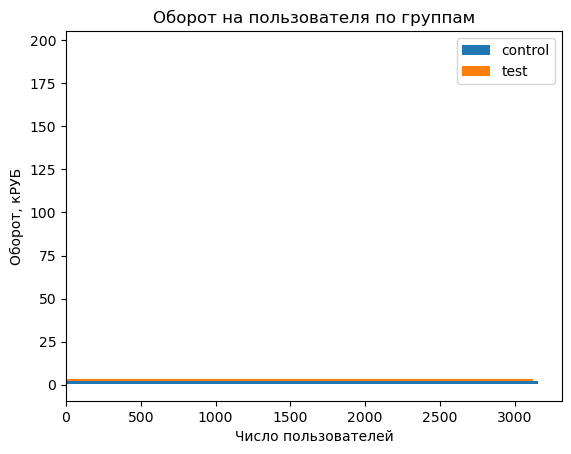

In [21]:
plt.hist([control.REVENUE, test.REVENUE], bins = 50, orientation='horizontal')
ax = plt.gca()
plt.title('Оборот на пользователя по группам')
plt.ylabel('Оборот, кРУБ')
plt.xlabel('Число пользователей')
plt.legend(labels=['control', 'test']);

#### Посмотрим на график в масштабе:

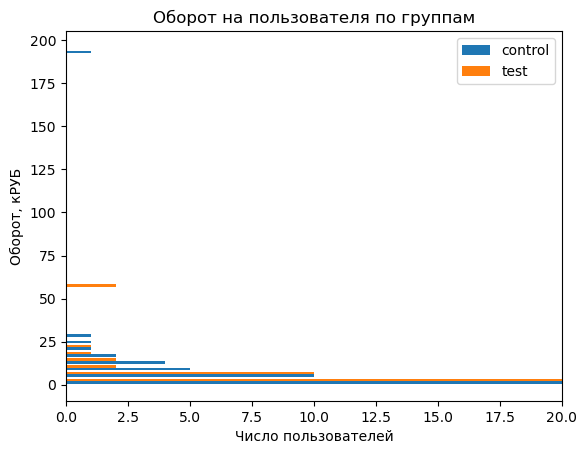

In [22]:
plt.hist([control.REVENUE, test.REVENUE], bins = 50, orientation='horizontal')
ax = plt.gca()
# ax.set_ylim([0, 20])
ax.set_xlim([0, 20])
plt.title('Оборот на пользователя по группам')
plt.ylabel('Оборот, кРУБ')
plt.xlabel('Число пользователей')
plt.legend(labels=['control', 'test']);

In [23]:
mw_stats = stats.mannwhitneyu(x=control.REVENUE.values, y=test.REVENUE.values)
mw_stats

MannwhitneyuResult(statistic=5015157.5, pvalue=0.34139468906780146)

#### Статистически значимой разницы между группами нет.

Попробуем удалить "выбросы". Будем считать "выбросами" все значения оборота свыше 35 кРУБ.

In [24]:
df3a = df3.drop(df3[df3.REVENUE > 35].index)
df3a

,USER_ID,VARIANT_NAME,REVENUE
0,2,control,0.0
1,3,variant,0.0
2,4,variant,0.0
3,5,variant,0.0
4,6,variant,0.0
...,...,...,...
6319,9993,control,0.0
6320,9995,variant,0.0
6321,9996,control,0.0
6322,9998,control,0.0


In [25]:
control3a = df3a.query('VARIANT_NAME == "control"')
test3a = df3a.query('VARIANT_NAME == "variant"')

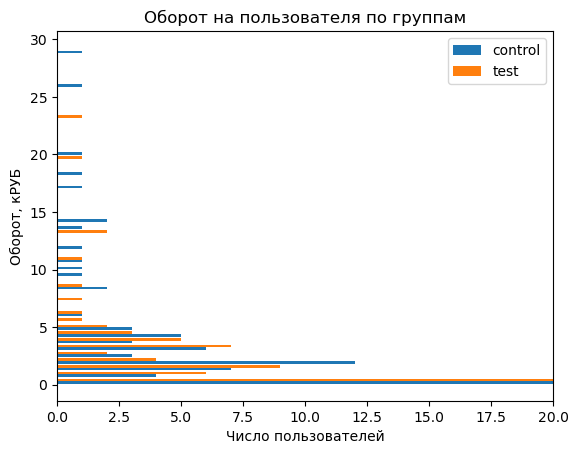

In [26]:
plt.hist([control3a.REVENUE, test3a.REVENUE], bins = 50, orientation='horizontal')
ax = plt.gca()
# ax.set_ylim([0, 20])
ax.set_xlim([0, 20])
plt.title('Оборот на пользователя по группам')
plt.ylabel('Оборот, кРУБ')
plt.xlabel('Число пользователей')
plt.legend(labels=['control', 'test']);

In [27]:
mw_stats3a = stats.mannwhitneyu(x=control3a.REVENUE.values, y=test3a.REVENUE.values)
mw_stats3a

MannwhitneyuResult(statistic=5012016.5, pvalue=0.28940682291123865)


#### Попробуем убрать из выборки всех пользователей с нулевым оборотом.
Сначала оценим, какой процент таких пользователей в каждой из групп:

In [28]:
x1 = df3[(df3.VARIANT_NAME == 'control') & (df3.REVENUE == 0)].shape[0]/df3[df3.VARIANT_NAME == 'control'].shape[0]
x2 = df3[(df3.VARIANT_NAME == 'variant') & (df3.REVENUE == 0)].shape[0]/df3[df3.VARIANT_NAME == 'variant'].shape[0]

print('Процент нулевых пользователей: ', 'в котрольной группе = {0:.1f}% , в вариативной группе = {1:.1f}%.'.format(x1*100, x2*100))

Процент нулевых пользователей:  в котрольной группе = 98.0% , в вариативной группе = 98.3%.


#### Процент соизмерим. Поэтому попробуем удалить всех нулевых пользователей и повторно сравнить выборки.

In [29]:
df4 = df3.drop(df3[df3.REVENUE == 0].index)
df4

,USER_ID,VARIANT_NAME,REVENUE
32,56,variant,2.99
75,124,control,1.25
104,169,control,4.33
174,282,control,18.56
277,443,variant,3.75
...,...,...,...
6004,9491,control,2.34
6022,9520,variant,5.08
6116,9661,control,3.24
6184,9766,control,3.79


#### Осталось всего чуть более 100 значений.

In [30]:
control4 = df4.query('VARIANT_NAME == "control"')
test4 = df4.query('VARIANT_NAME == "variant"')

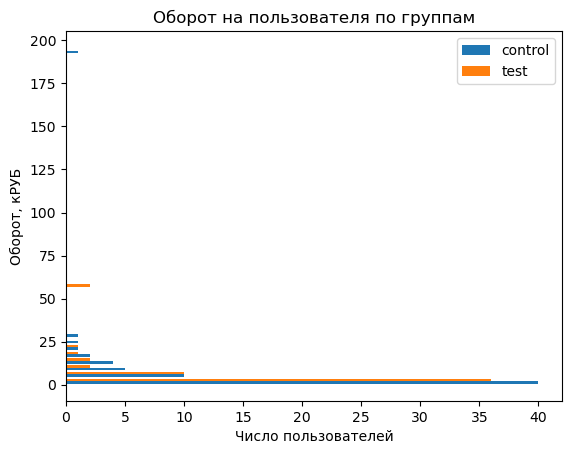

In [31]:
plt.hist([control4.REVENUE, test4.REVENUE], bins = 50, orientation='horizontal')
ax = plt.gca()

plt.title('Оборот на пользователя по группам')
plt.ylabel('Оборот, кРУБ')
plt.xlabel('Число пользователей')
plt.legend(labels=['control', 'test']);

In [32]:
mw_stats4 = stats.mannwhitneyu(x=control4.REVENUE.values, y=test4.REVENUE.values)
mw_stats4

MannwhitneyuResult(statistic=1869.5, pvalue=0.54280059427001)

#### По-прежнему нет существенных различий между 2 группами. 

### ВЫВОД: 
1. Рекомендую основывать принятие решения о дальнейших действиях на других факторах, так как результаты эксперимента не показывают значительного влияния изменений на показатели.
2. Еще одним вариантом будет проведение повторного эксперимента.
3. Необходимо дополнительно оценить время и параметры проведения эксперимента. 
4. Прошу обратить особое внимание на качество сбора данных. Данные были сильно искажены - очень много повторов среди пользователей.